# Prototype calculation of cabelling and mixing of density from CM2.6 data <a class="anchor" id="top"> </a>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
import gsw

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


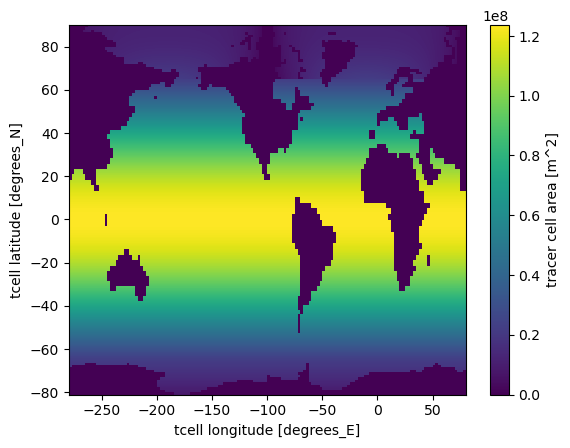

In [3]:
coord.area_t.plot()

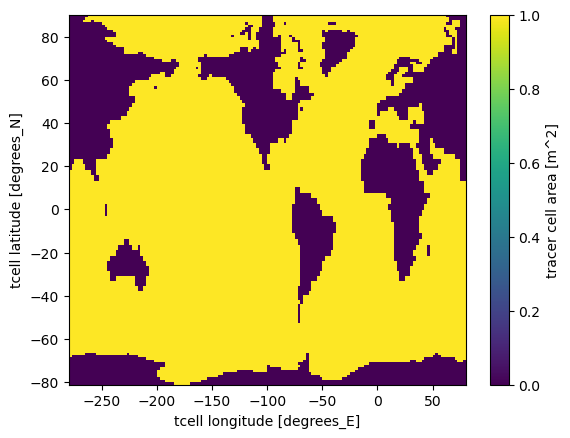

In [4]:
(coord.area_t.where(coord.area_t<=0, 1)).plot()

In [5]:
#hfacc = ds.temp.where(ds.temp == ds.temp.notnull(), 999).where(ds.temp < 999, 111)
#mask = hfacc==999
#mask = coord.area_t
mask = coord.area_t.where(coord.area_t<=0, 1)

In [6]:
wet_mask = mask#[0,0]
dxt = coord.dxt
dyt = coord.dyt
dxu = coord.dxu
dyu = coord.dyu
area_t = coord.area_t

In [7]:
grid = xgcm.Grid(ds.drop_dims('time'), coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [8]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    area_t:   Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
    dxu:      Annotated[np.ndarray, "(Y:right, X:right)"],
    dyu:      Annotated[np.ndarray, "(Y:right, X:right)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian for MOM5 (tracer points).
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    Attributes
    __________
    For information on MOM5 discretization see: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxt: width in x of T-cell, model diagnostic dxt
    dyt: height in y of T-cell, model diagnostic dyt
    dxu: width in x of U-cell, model diagnostic dxu
    dyu: height in y of U-cell, model diagnostic dyu
    area_t: area of T-cell, dxt*dyt
    """    
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
#    np = get_array_module(tracer)
    tracer = np.nan_to_num(tracer)
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    fx /= dxu + np.roll(dxu, 1, axis=-1)
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    fy /= dyu + np.roll(dyu, 1, axis=-2)
    fx *= x_wet_mask
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyt + np.roll(dyt, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyt + np.roll(dyt, 1, axis=-2))
    )
    out1 /= area_t

    out2 = fy * 0.5 * (dxt + np.roll(dxt, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxt + np.roll(dxt, 1, axis=-1))
    )
    out2 /= area_t
    return out1 + out2

In [9]:
axis = 7*[('Y','X')]

In [10]:
temp = ds.temp.isel(time=slice(0,3), st_ocean=0)

In [11]:
test = Laplacian(grid, wet_mask, dxt, dyt, area_t, temp, dxu, dyu, axis=axis)

In [14]:
test

<xarray.DataArray (time: 3, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(3, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0181-03-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

/tmp/ipykernel_626/75826970.py:39: RuntimeWarning: divide by zero encountered in divide
  out1 /= area_t
/tmp/ipykernel_626/75826970.py:39: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_626/75826970.py:45: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t


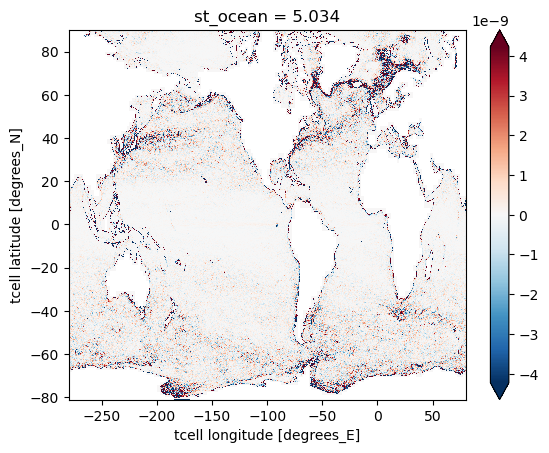

In [13]:
test.mean('time').plot(robust=True)

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>

In [18]:
sa_whole = gsw.SA_from_SP(ds.salt, 0, ds.xt_ocean, ds.yt_ocean)
ct_whole = gsw.CT_from_pt(sa_whole, ds.temp)

sa = sa_whole.isel(st_ocean=0)
ct = ct_whole.isel(st_ocean=0)

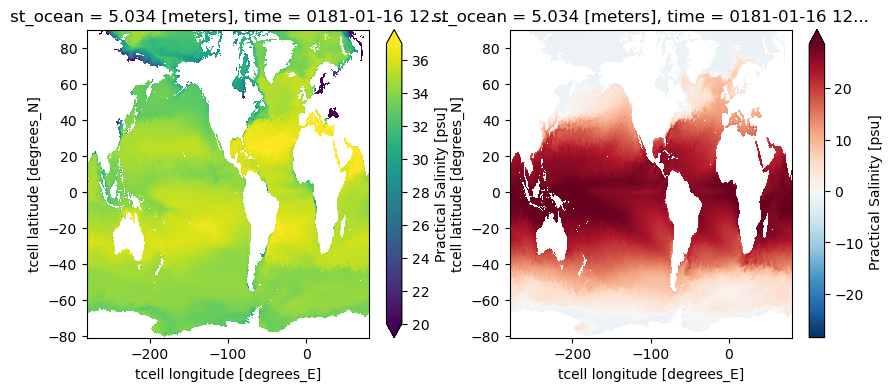

In [19]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
sa[0].plot(vmin=20, vmax=37, ax=ax0)
ct[0].plot(robust=True, ax=ax1)

In [20]:
SST_lap = Laplacian(grid, wet_mask, dxt, dyt, area_t, ct, dxu, dyu, axis=axis)
SSS_lap = Laplacian(grid, wet_mask, dxt, dyt, area_t, sa, dxu, dyu, axis=axis)

In [21]:
SSS_lap

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(240, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

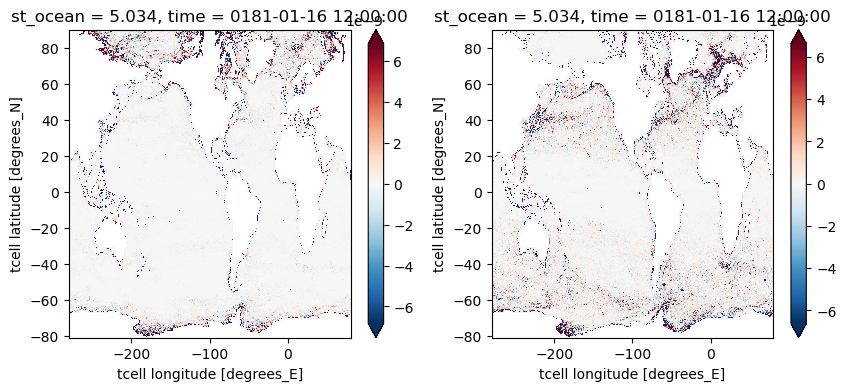

In [22]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
SSS_lap[0].plot(robust=True, ax=ax0)
SST_lap[0].plot(robust=True, ax=ax1)
plt.tight_layout();

# 2) Convert to density tendency <a class="anchor" id='second-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [23]:
rho = gsw.rho(sa, ct, 0)

In [24]:
rho

<xarray.DataArray 'salt' (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<rho, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    long_name:      Practical Salinity
    standard_name:  sea_water_salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10.0, 100.0]

In [25]:
drhodt = gsw.density.alpha(sa, ct, 0)
drhods = gsw.density.beta(sa, ct, 0)

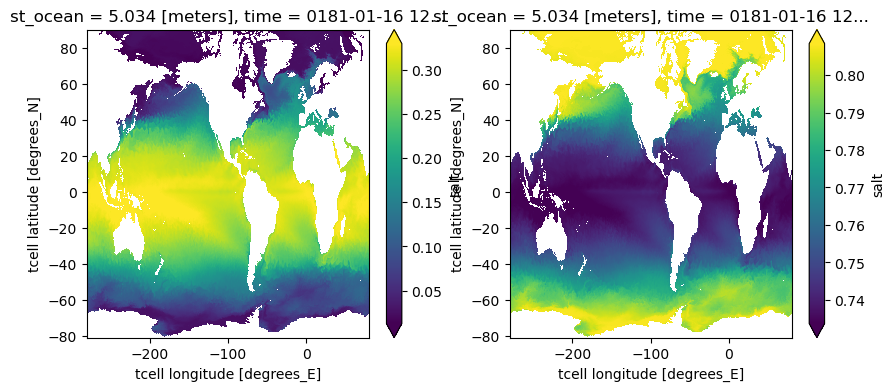

In [26]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
(rho*drhodt)[0].plot(robust=True, ax=ax0)
(rho*drhods)[0].plot(robust=True, ax=ax1)
plt.tight_layout();

In [27]:
dens_tend = rho * (drhodt * SST_lap + drhods * SSS_lap)
dens_tend

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

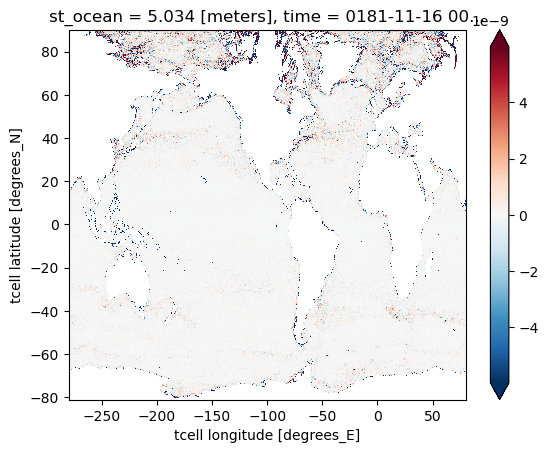

In [28]:
dens_tend.isel(time=10).plot(robust=True);

[Back to top](#top)

# 3) Decompose into the following form <a class='anchor' id='third-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [29]:
rho_lap = Laplacian(grid, wet_mask, dxt, dyt, area_t, rho, dxu, dyu, axis=axis)

rho_lap

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(240, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

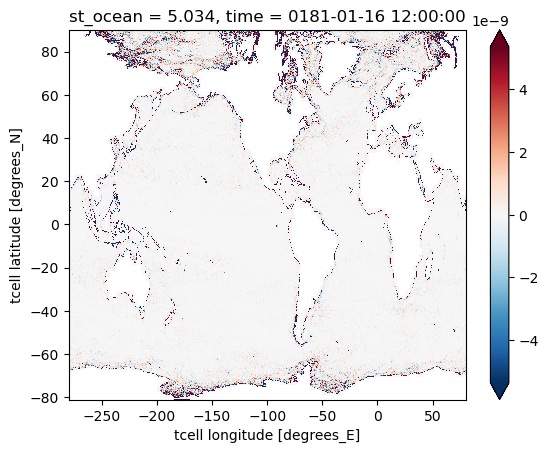

In [30]:
rho_lap[0].plot(robust=True);

In [31]:
cabbeling = dens_tend - rho_lap

In [32]:
cabbeling

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<sub, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [33]:
selection = dict(xt_ocean=slice(-75,-25), yt_ocean=slice(25,60))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

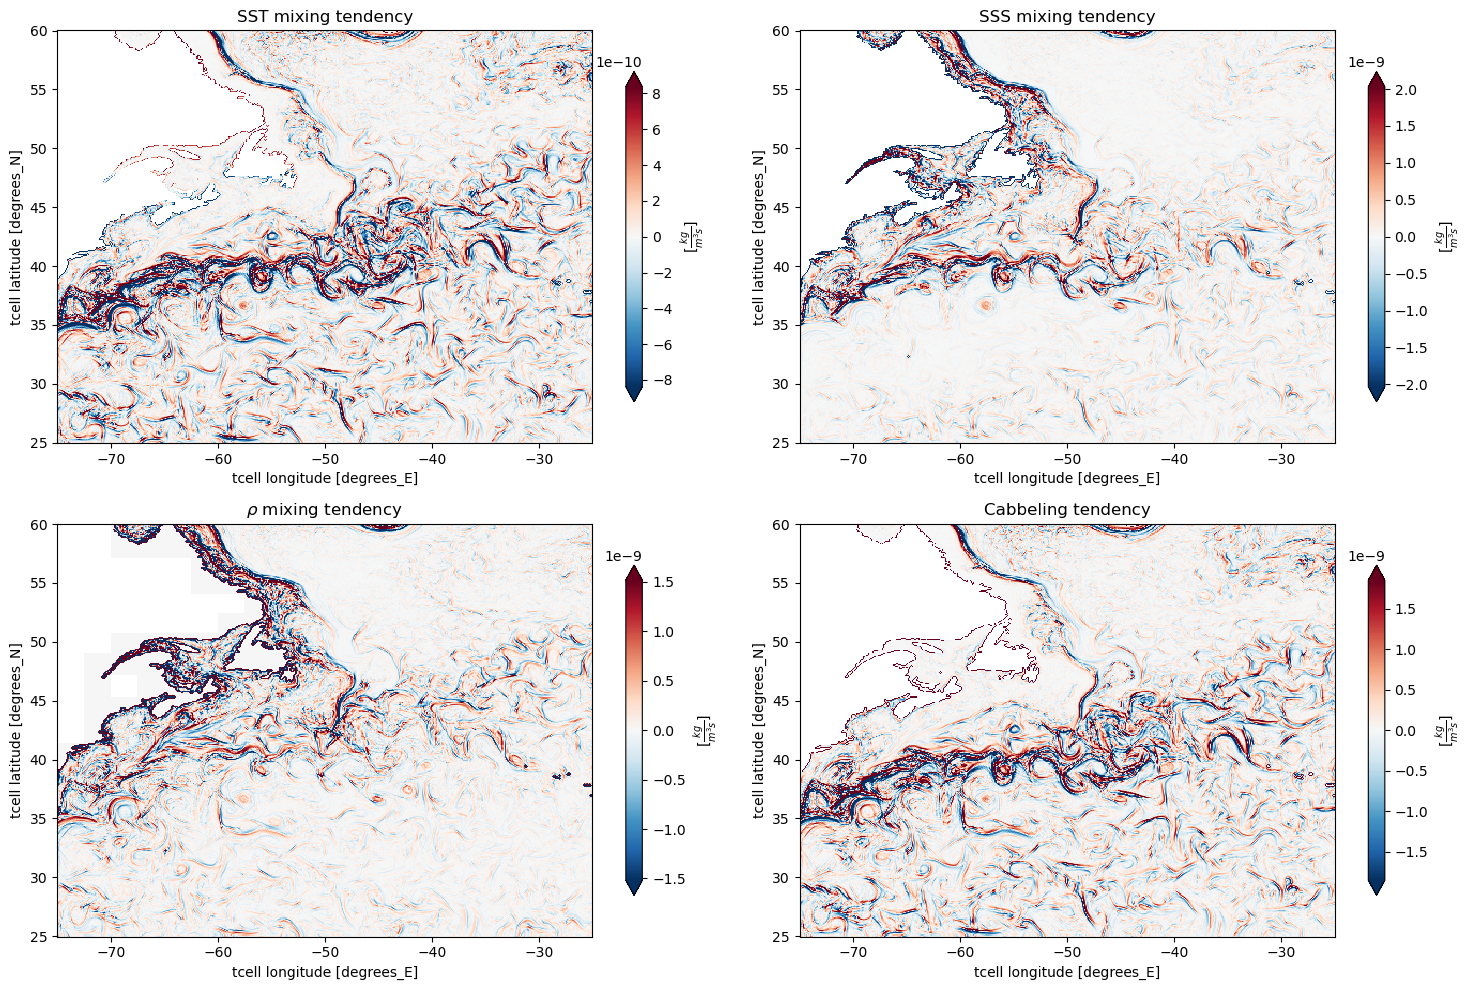

In [34]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(rho*SST_lap*drhodt).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(rho*SSS_lap*drhods).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_lap).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

## 4) Save the four terms to dataset <a class="anchor" id="fourth-bullet"> </a>

In [35]:
client.restart()

<Client: 'tls://10.0.15.27:8786' processes=0 threads=0, memory=0 B>

In [36]:
rho_lap#.drop(['geolon_t', 'geolat_t'])

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(240, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [37]:
tendencies = xr.merge([SST_lap.rename('SST_lap'), SSS_lap.rename('SSS_lap'),
                       drhodt.rename('drhodt'), drhods.rename('drhods'), 
                       rho_lap.drop(['geolon_t', 'geolat_t']).rename('rho_lap'), cabbeling.rename('cabbeling'),
                      rho.rename('rho')])
tendencies = tendencies.drop(['st_ocean', 'geolat_t', 'geolon_t'])

In [38]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 240, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    SST_lap    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SSS_lap    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    drhodt     (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    drhods     (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [39]:
tracers = xr.merge([tendencies.SST_lap.rename('SST_lap'), 
                    tendencies.SSS_lap.rename('SSS_lap')])
drhodts = xr.merge([tendencies.drhodt.rename('drhodt'), 
                    tendencies.drhods.rename('drhods')])
rho_lap_cab = xr.merge([tendencies.rho_lap.rename('rho_lap'),
                        tendencies.rho.rename('rho'),
                        tendencies.cabbeling.rename('cabbeling')])

In [40]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [41]:
#uploading tracer tendency ds for entire 40 yr run
gcsmap_tracer_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/tracer_tendencies.zarr')
tracers.to_zarr(gcsmap_tracer_tendencies, mode='w')

In [ ]:
#uploading drhodts tendency ds for entire 40 yr run
gcsmap_drhodts_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/drhodts_tendencies.zarr')
drhodts.to_zarr(gcsmap_drhodts_tendencies, mode='w')

In [ ]:
#uploading rho_bih and cabbeling tendency ds for entire 40 yr run
gcsmap_rho_cab_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/rho_lap_cab_tendencies.zarr')
rho_lap_cab.to_zarr(gcsmap_rho_cab_tendencies, mode='w')

In [65]:
cluster.close()
client.close()